In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import sys
import os
import time
import pickle
import random

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam
from sklearn import metrics
from collections import OrderedDict 

sys.path.append(os.path.abspath(''))

import datasets
from utils.modules import Parallel, MaxLayer
from utils.custom_activations import StepActivation
from utils.misc import train_model, cov_score
from compiling_nn.build_odd import compile_nn
from compiling_nn.utils_odd import pickle_bdd, unpickle_bdd

seed = 2872
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

SAVE_PATH = os.path.join(os.path.abspath(''), "backup")
PKL_PATH = os.path.join(SAVE_PATH, "bdd")
PTH_PATH = os.path.join(SAVE_PATH, "nn")
METRIC_PATH = os.path.join(SAVE_PATH, "metrics")

## Load data

In [3]:
np_x, np_y = datasets.LoanDataset.get_dataset(balancing=True, discretizing=True, hot_encoding=True)
x_data, y_data = torch.Tensor(np_x), torch.Tensor(np_y)
input_size = x_data.size(1)
print(x_data.size())

torch.Size([296, 24])


In [4]:
def train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer):
    train_model(x_train, y_train, model, criterion, optimizer, 1)
    model.eval()
    pred_train = model(x_train).detach()
    pred_valid = model(x_valid).detach()

    f1_train = metrics.f1_score(y_train, pred_train)
    cov_train = cov_score(y_train, pred_train)
    f1_valid = metrics.f1_score(y_valid, pred_valid)
    cov_valid = cov_score(y_valid, pred_valid)

    return f1_train, cov_train, f1_valid, cov_valid

def print_eval(x_train, y_train, x_valid, y_valid, model, criterion, optimizer):
    f1_train, cov_train, f1_valid, cov_valid = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
    print(
        f"{'':<15}{'Train':^15}{'Valid':^15}",
        f"{'F1 score':<15}{f1_train:^15.3f}{f1_valid:^15.3f}",
        f"{'Coverage [0]':<15}{cov_train[0]:^15.3f}{cov_valid[0]:^15.3f}",
        f"{'         [1]':<15}{cov_train[1]:^15.3f}{cov_valid[1]:^15.3f}",
        sep="\n"
    )

## Network

In [5]:
class nApxNet(nn.Module):
    def __init__(self, n, hl=3) -> None:
        super().__init__()

        self.n_apx = n
        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
                (f'apx{i}', ApproxNet(hl)) for i in range(1, self.n_apx+1)
            ]))),
            ('or_', MaxLayer()),
        ]))


    def forward(self, input):
        return self.net(input)
    
    def add_apx(self, module):
        self.n_apx += 1
        self.net.nets.add_module(f'apx{self.n_apx}', module)
    
class ApproxNet(nn.Module):
    def __init__(self, hl1):
        super().__init__()
        self.nn = nn.Sequential(OrderedDict([
            ('l1', nn.Linear(input_size,hl1)),
            ('a1', StepActivation()),
            ('l2', nn.Linear(hl1,1)),
            ('a2', StepActivation())
        ]))        

    def forward(self, x):
        x = self.nn(x)

        return x

## Exp

In [6]:
def train_compile(x_train, y_train, x_valid, y_valid, hidden_neurons):
    exp_folder = "train_compile"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = {}
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, num_neurons)
        criterion = nn.BCELoss()
        optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

        f1t, covt, f1v , covv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)

        start = time.perf_counter()
        bdd = compile_nn(model.net.nets.apx1)
        time_to_build = time.perf_counter() - start
        bdd_size = len(list(bdd.dfs_postorder()))

        modelname = f"1apx{num_neurons}hl"
        torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))
        os.makedirs(os.path.join(PKL_PATH, exp_folder, modelname), exist_ok=True)
        pickle_bdd(bdd, os.path.join(PKL_PATH, exp_folder, modelname, "apx1.pkl"))
        print(f"DONE {num_neurons}")

        d_metrics.setdefault(('train', 'f1'), np.empty((1, len_hn)))[0, ihn] = f1t
        d_metrics.setdefault(('valid', 'f1'), np.empty((1, len_hn)))[0, ihn] = f1v
        d_metrics.setdefault(('train', 'cov0'), np.empty((1, len_hn)))[0, ihn] = covt[0]
        d_metrics.setdefault(('valid', 'cov0'), np.empty((1, len_hn)))[0, ihn] = covv[0]
        d_metrics.setdefault(('train', 'cov1'), np.empty((1, len_hn)))[0, ihn] = covt[1]
        d_metrics.setdefault(('valid', 'cov1'), np.empty((1, len_hn)))[0, ihn] = covv[1]
        d_metrics.setdefault('bdd_size', np.empty((1, len_hn)))[0, ihn] = bdd_size
        d_metrics.setdefault('time', np.empty((1, len_hn)))[0, ihn] = time_to_build

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

def train_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx):
    exp_folder = "train_expand"
    os.makedirs(os.path.join(PTH_PATH, exp_folder), exist_ok=True)
    d_metrics = dict()
    len_hn = len(hidden_neurons)
    for ihn, num_neurons in enumerate(hidden_neurons):
        model = nApxNet(1, hl=num_neurons)
        for iapx in range(n_apx):
            criterion = nn.BCELoss()
            optimizer = Adam(model.net.nets.parameters(), lr=1e-2, weight_decay=1e-6)

            f1t, covt, f1v , covv = train_eval_model(x_train, y_train, x_valid, y_valid, model, criterion, optimizer)
            
            d_metrics.setdefault(('train', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1t
            d_metrics.setdefault(('valid', 'f1'), np.empty((n_apx, len_hn)))[iapx, ihn] = f1v
            d_metrics.setdefault(('train', 'cov0'), np.empty((n_apx, len_hn)))[iapx, ihn] = covt[0]
            d_metrics.setdefault(('valid', 'cov0'), np.empty((n_apx, len_hn)))[iapx, ihn] = covv[0]
            d_metrics.setdefault(('train', 'cov1'), np.empty((n_apx, len_hn)))[iapx, ihn] = covt[1]
            d_metrics.setdefault(('valid', 'cov1'), np.empty((n_apx, len_hn)))[iapx, ihn] = covv[1]

            modelname = f"{iapx+1}apx{ihn}hl"
            torch.save(model.state_dict(), os.path.join(PTH_PATH, exp_folder, f"{modelname}.pth"))

            module = ApproxNet(num_neurons)
            model.add_apx(module)

    with open(os.path.join(METRIC_PATH, f"{exp_folder}.pkl"), 'wb') as f:
        pickle.dump(d_metrics, f)
    return d_metrics

In [7]:
train_index, valid_index = torch.utils.data.random_split(range(x_data.size(0)), [0.9, 0.1])

x_train, y_train = x_data[train_index], y_data[train_index]
x_valid, y_valid = x_data[valid_index], y_data[valid_index]

hidden_neurons = [3,5,7,10]
n_apx_max = 6

d_metrics = train_compile(x_train, y_train, x_valid, y_valid, hidden_neurons)
# d_metrics = train_expand(x_train, y_train, x_valid, y_valid, hidden_neurons, n_apx_max)

DONE 3
DONE 5
DONE 7
DONE 10


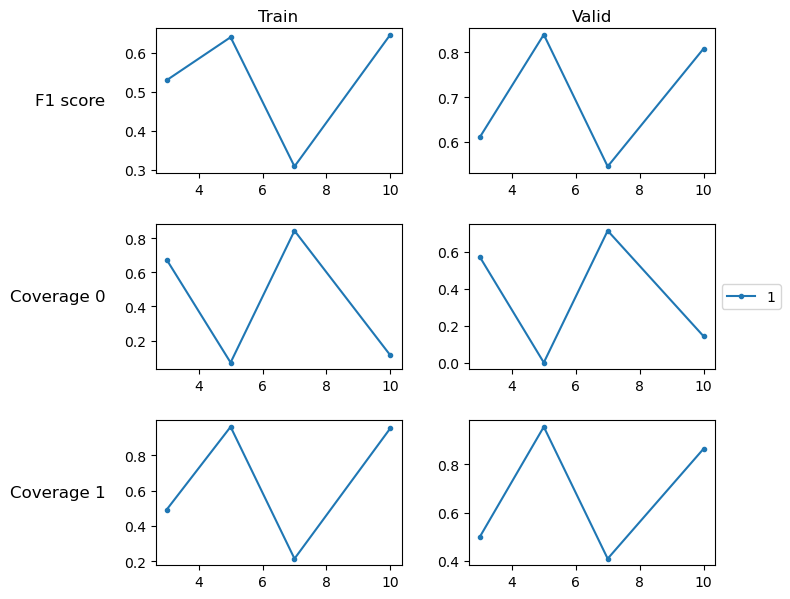

In [8]:
fig, axs = plt.subplots(3,2)

x_axis = hidden_neurons
for ax, metric in zip(axs.flat, d_metrics.values()):
    for n_apx, n_apx_metric in enumerate(metric):
        ax.plot(x_axis, n_apx_metric, marker='.', label=n_apx+1)
        
axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

cols = ["Train", "Valid"]
rows = ["F1 score", "Coverage 0", "Coverage 1"]

pad = 5
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0, top=1.2)

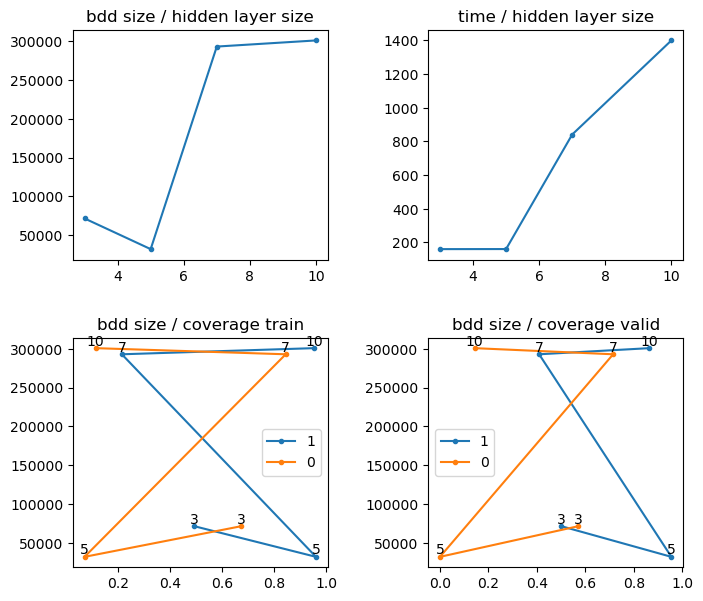

In [11]:
def custom_plot(ax, x_axis, y_axis, title=None, label=None, labels=None, marker='.'):
    ax.plot(x_axis, y_axis, marker=marker, label=label)
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        for x, y, label in zip(x_axis, y_axis, labels):
            ax.annotate(label, (x, y), textcoords="offset points", xytext=(0,2), ha="center")
    if label:
        ax.legend()

fig, axs = plt.subplots(2,2)
custom_plot(axs[0, 0], hidden_neurons, d_metrics["bdd_size"][0,:], "bdd size / hidden layer size")
custom_plot(axs[0, 1], hidden_neurons, d_metrics["time"][0,:], "time / hidden layer size")
custom_plot(axs[1, 0], d_metrics[('train', 'cov1')][0,:], d_metrics["bdd_size"][0,:], "bdd size / coverage train", label="1", labels=hidden_neurons)
custom_plot(axs[1, 0], d_metrics[('train', 'cov0')][0,:], d_metrics["bdd_size"][0,:], label="0", labels=hidden_neurons)
custom_plot(axs[1, 1], d_metrics[('valid', 'cov1')][0,:], d_metrics["bdd_size"][0,:], "bdd size / coverage valid", label="1", labels=hidden_neurons)
custom_plot(axs[1, 1], d_metrics[('valid', 'cov0')][0,:], d_metrics["bdd_size"][0,:], label="0", labels=hidden_neurons)

fig.tight_layout()
fig.subplots_adjust(left=0, top=1.2)